# 2022年MathorCup高校数学建模挑战赛D题 - 基站覆盖优化问题

本Notebook针对基站覆盖优化问题进行系统性的数据分析和数学建模，提供多种解题思路和方法。

## 问题背景
- **数据**: 现有基站位置 (current.csv) 和弱信号点 (weak.csv)
- **目标**: 优化基站布局，提高信号覆盖效果
- **约束**: 考虑建设成本、覆盖范围、流量需求等因素

## 数据说明
- **current.csv**: 现有基站数据 (id, x, y坐标)
- **weak.csv**: 弱信号点数据 (x, y坐标, 流量需求traffic)

## 解题思路框架
1. 数据读取与空间分布分析
2. 覆盖距离计算与分析
3. 基站选址优化模型
4. 聚类分析与区域划分
5. 结果可视化与方案评估

# 1. 数据读取与空间分布分析

读取现有基站和弱信号点数据，分析其空间分布特征。

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti', 'PingFang TC', 'Hiragino Sans GB']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("库导入完成！")

库导入完成！


In [2]:
# 读取基站和弱信号点数据
current_stations = pd.read_csv('current.csv')  # 现有基站
weak_points = pd.read_csv('weak.csv')         # 弱信号点

print("=== 现有基站数据 ===")
print(f"基站数量: {len(current_stations)}")
print(f"数据列: {list(current_stations.columns)}")
print("\n基站数据前5行:")
print(current_stations.head())

print("\n=== 弱信号点数据 ===")
print(f"弱信号点数量: {len(weak_points)}")
print(f"数据列: {list(weak_points.columns)}")
print("\n弱信号点数据前5行:")
print(weak_points.head())

print("\n=== 数据基本统计 ===")
print("现有基站坐标范围:")
print(f"X坐标: [{current_stations['x'].min()}, {current_stations['x'].max()}]")
print(f"Y坐标: [{current_stations['y'].min()}, {current_stations['y'].max()}]")

print("\n弱信号点坐标范围:")
print(f"X坐标: [{weak_points['x'].min()}, {weak_points['x'].max()}]")
print(f"Y坐标: [{weak_points['y'].min()}, {weak_points['y'].max()}]")

print(f"\n流量需求统计:")
print(f"总流量需求: {weak_points['traffic'].sum():.2f}")
print(f"平均流量需求: {weak_points['traffic'].mean():.2f}")
print(f"最大流量需求: {weak_points['traffic'].max():.2f}")
print(f"最小流量需求: {weak_points['traffic'].min():.2f}")

=== 现有基站数据 ===
基站数量: 1474
数据列: ['id', 'x', 'y']

基站数据前5行:
   id     x     y
0   1   818  2020
1   4   713  2013
2  33  2305   291
3  35   700  1953
4  36   949  2293

=== 弱信号点数据 ===
弱信号点数量: 182807
数据列: ['x', 'y', 'traffic']

弱信号点数据前5行:
     x     y     traffic
0   66  1486  140.581390
1   67  1486  140.518829
2  177  1486   48.919178
3  187  1486    4.322495
4  284  1486   71.528404

=== 数据基本统计 ===
现有基站坐标范围:
X坐标: [1, 2499]
Y坐标: [1, 2499]

弱信号点坐标范围:
X坐标: [0, 2499]
Y坐标: [0, 2499]

流量需求统计:
总流量需求: 7056230.11
平均流量需求: 38.60
最大流量需求: 47795.01
最小流量需求: 0.00


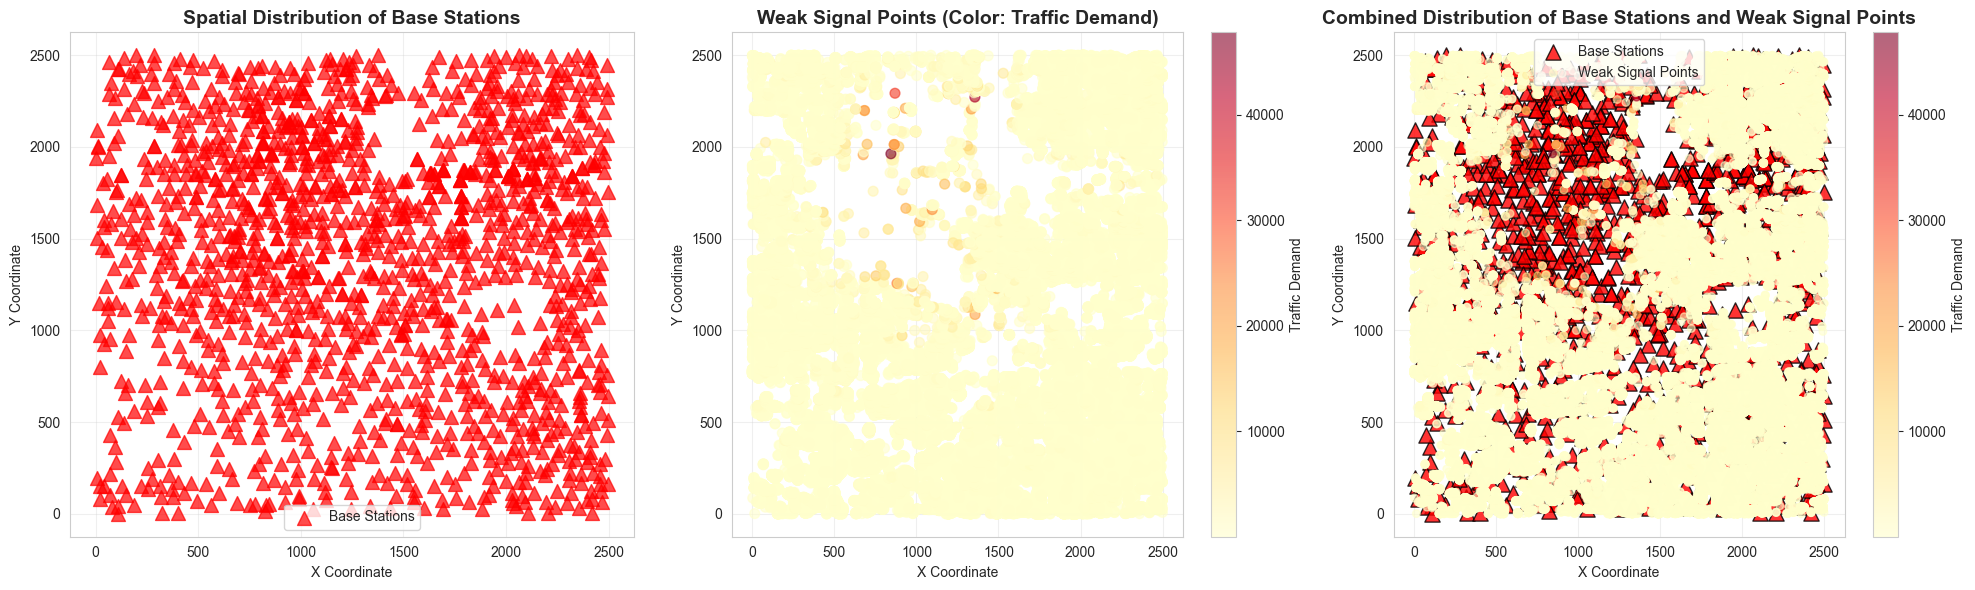

In [3]:
# Spatial distribution visualization (English labels)
def plot_spatial_distribution():
    """
    Plot spatial distribution of base stations and weak signal points
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Base station distribution
    axes[0].scatter(current_stations['x'], current_stations['y'], 
                   c='red', s=100, alpha=0.7, marker='^', label='Base Stations')
    axes[0].set_title('Spatial Distribution of Base Stations', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('X Coordinate')
    axes[0].set_ylabel('Y Coordinate')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Weak signal points distribution (colored by traffic)
    scatter = axes[1].scatter(weak_points['x'], weak_points['y'], 
                             c=weak_points['traffic'], s=50, alpha=0.6, 
                             cmap='YlOrRd', label='Weak Signal Points')
    axes[1].set_title('Weak Signal Points (Color: Traffic Demand)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=axes[1], label='Traffic Demand')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Combined distribution
    axes[2].scatter(current_stations['x'], current_stations['y'], 
                   c='red', s=120, alpha=0.8, marker='^', label='Base Stations', edgecolor='black')
    scatter2 = axes[2].scatter(weak_points['x'], weak_points['y'], 
                              c=weak_points['traffic'], s=30, alpha=0.6, 
                              cmap='YlOrRd', label='Weak Signal Points')
    axes[2].set_title('Combined Distribution of Base Stations and Weak Signal Points', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('X Coordinate')
    axes[2].set_ylabel('Y Coordinate')
    axes[2].legend()
    plt.colorbar(scatter2, ax=axes[2], label='Traffic Demand')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot spatial distribution
plot_spatial_distribution()

# 2. 覆盖距离计算与分析

分析基站覆盖范围与弱信号点的关系，为选址优化提供基础数据。

In [4]:
# 定义基站类型和参数
class BaseStationType:
    """基站类型定义"""
    def __init__(self, name, coverage_radius, cost):
        self.name = name
        self.coverage_radius = coverage_radius
        self.cost = cost
    
    def __str__(self):
        return f"{self.name}(覆盖半径:{self.coverage_radius}, 成本:{self.cost})"

# 定义两种基站类型
MACRO_STATION = BaseStationType("宏基站", 30, 10)
MICRO_STATION = BaseStationType("微基站", 10, 1)

print("基站类型定义:")
print(f"- {MACRO_STATION}")
print(f"- {MICRO_STATION}")

# 距离门限
DISTANCE_THRESHOLD = 10

print(f"\n基站间距离门限: {DISTANCE_THRESHOLD}")
print(f"覆盖目标: 90%的业务量")

def calculate_distance(point1, point2):
    """计算两点间的欧几里得距离"""
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_coverage(stations, weak_points, station_type):
    """
    计算给定基站配置下的覆盖情况
    
    Args:
        stations: 基站坐标数组 [(x1, y1), (x2, y2), ...]
        weak_points: 弱信号点数据DataFrame
        station_type: 基站类型对象
    
    Returns:
        覆盖的业务量, 覆盖的点数, 覆盖详情
    """
    coverage_radius = station_type.coverage_radius
    covered_traffic = 0
    covered_points = 0
    coverage_details = []
    
    for idx, point in weak_points.iterrows():
        point_coord = (point['x'], point['y'])
        is_covered = False
        
        for station in stations:
            distance = calculate_distance(station, point_coord)
            if distance <= coverage_radius:
                is_covered = True
                break
        
        if is_covered:
            covered_traffic += point['traffic']
            covered_points += 1
            coverage_details.append({
                'point_id': idx,
                'x': point['x'],
                'y': point['y'],
                'traffic': point['traffic'],
                'covered': True
            })
        else:
            coverage_details.append({
                'point_id': idx,
                'x': point['x'],
                'y': point['y'],
                'traffic': point['traffic'],
                'covered': False
            })
    
    return covered_traffic, covered_points, coverage_details

def check_distance_constraint(stations, existing_stations, threshold=DISTANCE_THRESHOLD):
    """
    检查基站间距离约束
    
    Args:
        stations: 新建基站坐标列表
        existing_stations: 现有基站坐标列表
        threshold: 距离门限
    
    Returns:
        是否满足约束, 违反约束的基站对
    """
    all_stations = list(existing_stations) + list(stations)
    violations = []
    
    for i in range(len(all_stations)):
        for j in range(i + 1, len(all_stations)):
            distance = calculate_distance(all_stations[i], all_stations[j])
            if distance < threshold:
                violations.append((i, j, distance))
    
    return len(violations) == 0, violations

print("\n距离计算和覆盖分析函数定义完成！")

基站类型定义:
- 宏基站(覆盖半径:30, 成本:10)
- 微基站(覆盖半径:10, 成本:1)

基站间距离门限: 10
覆盖目标: 90%的业务量

距离计算和覆盖分析函数定义完成！


In [5]:
# 分析现有基站分布和弱信号点特征
print("=== 现有基站覆盖能力分析 ===")

# 转换现有基站坐标为元组列表
existing_station_coords = [(row['x'], row['y']) for _, row in current_stations.iterrows()]

# 计算总业务量和目标覆盖量
total_traffic = weak_points['traffic'].sum()
target_coverage = 0.9 * total_traffic

print(f"弱信号点总数: {len(weak_points)}")
print(f"总业务量: {total_traffic:.2f}")
print(f"目标覆盖业务量 (90%): {target_coverage:.2f}")

# 分析弱信号点的业务量分布
traffic_stats = weak_points['traffic'].describe()
print(f"\n业务量分布统计:")
print(traffic_stats)

# 计算弱信号点之间的距离分布
def analyze_point_density():
    """分析弱信号点的密度分布"""
    # 随机选择部分点计算距离（避免计算量过大）
    sample_size = min(1000, len(weak_points))
    sample_points = weak_points.sample(n=sample_size, random_state=42)
    
    distances = []
    for i, point1 in sample_points.iterrows():
        for j, point2 in sample_points.iterrows():
            if i < j:  # 避免重复计算
                dist = calculate_distance((point1['x'], point1['y']), 
                                        (point2['x'], point2['y']))
                distances.append(dist)
    
    distances = np.array(distances)
    return {
        'mean_distance': np.mean(distances),
        'median_distance': np.median(distances),
        'min_distance': np.min(distances),
        'max_distance': np.max(distances),
        'std_distance': np.std(distances)
    }

density_stats = analyze_point_density()
print(f"\n弱信号点密度分析 (基于样本):")
for key, value in density_stats.items():
    print(f"{key}: {value:.2f}")

# 分析高业务量点的分布
high_traffic_threshold = weak_points['traffic'].quantile(0.8)  # 前20%高业务量点
high_traffic_points = weak_points[weak_points['traffic'] >= high_traffic_threshold].copy()

print(f"\n高业务量点分析 (阈值: {high_traffic_threshold:.2f}):")
print(f"高业务量点数量: {len(high_traffic_points)}")
print(f"高业务量点总业务量: {high_traffic_points['traffic'].sum():.2f}")
print(f"占总业务量比例: {high_traffic_points['traffic'].sum() / total_traffic * 100:.1f}%")

=== 现有基站覆盖能力分析 ===
弱信号点总数: 182807
总业务量: 7056230.11
目标覆盖业务量 (90%): 6350607.10

业务量分布统计:
count    182807.000000
mean         38.599343
std         336.383875
min           0.000192
25%           0.596106
50%           3.604328
75%          17.901928
max       47795.011719
Name: traffic, dtype: float64

弱信号点密度分析 (基于样本):
mean_distance: 1382.59
median_distance: 1404.04
min_distance: 1.00
max_distance: 3457.83
std_distance: 704.97

高业务量点分析 (阈值: 25.97):
高业务量点数量: 36562
高业务量点总业务量: 6367675.45
占总业务量比例: 90.2%

弱信号点密度分析 (基于样本):
mean_distance: 1382.59
median_distance: 1404.04
min_distance: 1.00
max_distance: 3457.83
std_distance: 704.97

高业务量点分析 (阈值: 25.97):
高业务量点数量: 36562
高业务量点总业务量: 6367675.45
占总业务量比例: 90.2%


# 3. 基站选址优化模型

基于贪心算法和聚类分析的基站选址优化方案，考虑覆盖需求、成本效益和距离约束。

In [6]:
class BaseStationOptimizer:
    """基站选址优化器"""
    
    def __init__(self, weak_points, existing_stations, macro_station, micro_station, 
                 distance_threshold=10, target_coverage_ratio=0.9):
        self.weak_points = weak_points.copy()
        self.existing_stations = existing_stations
        self.macro_station = macro_station
        self.micro_station = micro_station
        self.distance_threshold = distance_threshold
        self.target_coverage_ratio = target_coverage_ratio
        self.total_traffic = weak_points['traffic'].sum()
        self.target_traffic = self.target_coverage_ratio * self.total_traffic
        
        # 生成候选站址（2500x2500网格）
        self.candidate_sites = self._generate_candidate_sites()
        print(f"生成候选站址数量: {len(self.candidate_sites)}")
    
    def _generate_candidate_sites(self):
        """生成候选站址（智能筛选，减少计算量）"""
        # 基于弱信号点分布生成候选站址
        candidates = []
        
        # 方法1: 基于弱信号点周围区域
        for _, point in self.weak_points.iterrows():
            x, y = int(point['x']), int(point['y'])
            # 在每个弱信号点周围生成候选点
            for dx in range(-20, 21, 5):  # 减少候选点密度
                for dy in range(-20, 21, 5):
                    new_x, new_y = x + dx, y + dy
                    if 0 <= new_x <= 2499 and 0 <= new_y <= 2499:
                        candidates.append((new_x, new_y))
        
        # 方法2: 网格采样
        step = 25  # 网格步长
        for x in range(0, 2500, step):
            for y in range(0, 2500, step):
                candidates.append((x, y))
        
        # 去重并过滤违反距离约束的候选点
        candidates = list(set(candidates))
        valid_candidates = []
        
        existing_coords = [(row['x'], row['y']) for _, row in self.existing_stations.iterrows()]
        
        for candidate in candidates:
            # 检查与现有基站的距离约束
            valid = True
            for existing in existing_coords:
                if calculate_distance(candidate, existing) < self.distance_threshold:
                    valid = False
                    break
            if valid:
                valid_candidates.append(candidate)
        
        return valid_candidates
    
    def calculate_station_benefit(self, station_coord, station_type, current_covered_points):
        """
        计算在指定位置建设指定类型基站的效益
        
        Args:
            station_coord: 基站坐标
            station_type: 基站类型
            current_covered_points: 当前已覆盖的点集合
        
        Returns:
            新增覆盖业务量, 成本效益比
        """
        new_covered_traffic = 0
        new_covered_count = 0
        
        for idx, point in self.weak_points.iterrows():
            if idx in current_covered_points:
                continue  # 已被覆盖
            
            point_coord = (point['x'], point['y'])
            distance = calculate_distance(station_coord, point_coord)
            
            if distance <= station_type.coverage_radius:
                new_covered_traffic += point['traffic']
                new_covered_count += 1
        
        # 计算成本效益比（每单位成本覆盖的业务量）
        benefit_ratio = new_covered_traffic / station_type.cost if station_type.cost > 0 else 0
        
        return new_covered_traffic, benefit_ratio, new_covered_count
    
    def greedy_optimization(self, max_stations=50):
        """
        贪心算法优化基站选址
        
        Args:
            max_stations: 最大基站数量限制
        
        Returns:
            选择的基站列表 [(x, y, station_type), ...]
        """
        selected_stations = []
        covered_points = set()
        covered_traffic = 0
        iteration_history = []
        
        print("开始贪心优化算法...")
        
        while covered_traffic < self.target_traffic and len(selected_stations) < max_stations:
            best_benefit = 0
            best_station = None
            best_type = None
            best_new_covered = 0
            
            # 遍历所有候选站址和基站类型
            for candidate in self.candidate_sites:
                # 检查与已选基站的距离约束
                valid = True
                for selected_coord, _ in selected_stations:
                    if calculate_distance(candidate, selected_coord) < self.distance_threshold:
                        valid = False
                        break
                
                if not valid:
                    continue
                
                # 尝试两种基站类型
                for station_type in [self.macro_station, self.micro_station]:
                    traffic, benefit_ratio, count = self.calculate_station_benefit(
                        candidate, station_type, covered_points
                    )
                    
                    # 选择效益最高的方案
                    if benefit_ratio > best_benefit and traffic > 0:
                        best_benefit = benefit_ratio
                        best_station = candidate
                        best_type = station_type
                        best_new_covered = traffic
            
            if best_station is None:
                print("无法找到更多有效的基站位置")
                break
            
            # 添加最佳基站
            selected_stations.append((best_station, best_type))
            
            # 更新已覆盖点集合
            for idx, point in self.weak_points.iterrows():
                if idx not in covered_points:
                    point_coord = (point['x'], point['y'])
                    distance = calculate_distance(best_station, point_coord)
                    if distance <= best_type.coverage_radius:
                        covered_points.add(idx)
                        covered_traffic += point['traffic']
            
            # 记录迭代历史
            iteration_history.append({
                'iteration': len(selected_stations),
                'station_coord': best_station,
                'station_type': best_type.name,
                'new_traffic': best_new_covered,
                'total_traffic': covered_traffic,
                'coverage_ratio': covered_traffic / self.total_traffic,
                'total_cost': sum(station[1].cost for station in selected_stations)
            })
            
            print(f"迭代 {len(selected_stations)}: 在 {best_station} 建设{best_type.name}, "
                  f"新增业务量: {best_new_covered:.2f}, "
                  f"总覆盖率: {covered_traffic/self.total_traffic:.3f}")
            
            if covered_traffic >= self.target_traffic:
                print(f"达到目标覆盖率 {self.target_coverage_ratio:.1%}!")
                break
        
        return selected_stations, iteration_history, covered_points

# 创建优化器实例
optimizer = BaseStationOptimizer(
    weak_points=weak_points,
    existing_stations=current_stations,
    macro_station=MACRO_STATION,
    micro_station=MICRO_STATION,
    distance_threshold=DISTANCE_THRESHOLD,
    target_coverage_ratio=0.9
)

print("基站选址优化器初始化完成！")

生成候选站址数量: 2715543
基站选址优化器初始化完成！


In [ ]:
# 执行贪心优化算法
print("=== 执行基站选址优化 ===")

# 运行贪心算法
selected_stations, optimization_history, covered_points = optimizer.greedy_optimization(max_stations=30)

print(f"\n=== 优化结果摘要 ===")
print(f"选择的基站数量: {len(selected_stations)}")

# 统计基站类型
macro_count = sum(1 for _, station_type in selected_stations if station_type.name == "宏基站")
micro_count = sum(1 for _, station_type in selected_stations if station_type.name == "微基站")
total_cost = sum(station_type.cost for _, station_type in selected_stations)

print(f"宏基站数量: {macro_count}")
print(f"微基站数量: {micro_count}")
print(f"总建设成本: {total_cost}")

# 计算最终覆盖情况
final_covered_traffic = sum(weak_points.loc[covered_points, 'traffic'])
final_coverage_ratio = final_covered_traffic / optimizer.total_traffic

print(f"覆盖的业务量: {final_covered_traffic:.2f}")
print(f"覆盖率: {final_coverage_ratio:.3f} ({final_coverage_ratio*100:.1f}%)")
print(f"目标覆盖率: {optimizer.target_coverage_ratio:.3f} ({optimizer.target_coverage_ratio*100:.1f}%)")

# 详细结果
print(f"\n=== 选择的基站详细信息 ===")
result_summary = []
for i, (coord, station_type) in enumerate(selected_stations, 1):
    x, y = coord
    result_summary.append({
        '序号': i,
        'X坐标': x,
        'Y坐标': y,
        '基站类型': station_type.name,
        '覆盖半径': station_type.coverage_radius,
        '建设成本': station_type.cost
    })
    print(f"{i:2d}. 坐标: ({x}, {y}), 类型: {station_type.name}")

# 转换为DataFrame便于后续分析
result_df = pd.DataFrame(result_summary)
print(f"\n基站选址结果DataFrame形状: {result_df.shape}")

=== 执行基站选址优化 ===
开始贪心优化算法...


# 4. 聚类分析与区域划分

使用聚类算法分析弱信号点分布，辅助优化基站选址策略。

In [ ]:
class ClusterBasedOptimizer:
    """基于聚类的基站选址优化器"""
    
    def __init__(self, weak_points, existing_stations, macro_station, micro_station, 
                 distance_threshold=10, target_coverage_ratio=0.9):
        self.weak_points = weak_points.copy()
        self.existing_stations = existing_stations
        self.macro_station = macro_station
        self.micro_station = micro_station
        self.distance_threshold = distance_threshold
        self.target_coverage_ratio = target_coverage_ratio
        self.total_traffic = weak_points['traffic'].sum()
        self.target_traffic = self.target_coverage_ratio * self.total_traffic
    
    def weighted_clustering(self, n_clusters=20):
        """
        基于业务量加权的聚类分析
        
        Args:
            n_clusters: 聚类数量
        
        Returns:
            聚类标签, 聚类中心
        """
        # 准备聚类数据（坐标 + 业务量权重）
        features = []
        weights = []
        
        for _, point in self.weak_points.iterrows():
            # 使用坐标和业务量作为特征
            features.append([point['x'], point['y'], point['traffic'] * 10])  # 放大业务量影响
            weights.append(point['traffic'])
        
        features = np.array(features)
        
        # 标准化特征
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # K-means聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features_scaled)
        
        # 计算真实坐标的聚类中心
        cluster_centers = []
        cluster_info = []
        
        for cluster_id in range(n_clusters):
            cluster_mask = cluster_labels == cluster_id
            cluster_points = self.weak_points[cluster_mask]
            
            if len(cluster_points) > 0:
                # 计算业务量加权中心
                weights_in_cluster = cluster_points['traffic'].values
                total_weight = weights_in_cluster.sum()
                
                if total_weight > 0:
                    center_x = (cluster_points['x'] * weights_in_cluster).sum() / total_weight
                    center_y = (cluster_points['y'] * weights_in_cluster).sum() / total_weight
                else:
                    center_x = cluster_points['x'].mean()
                    center_y = cluster_points['y'].mean()
                
                cluster_centers.append((int(center_x), int(center_y)))
                cluster_info.append({
                    'cluster_id': cluster_id,
                    'center': (int(center_x), int(center_y)),
                    'point_count': len(cluster_points),
                    'total_traffic': cluster_points['traffic'].sum(),
                    'avg_traffic': cluster_points['traffic'].mean(),
                    'max_traffic': cluster_points['traffic'].max()
                })
        
        return cluster_labels, cluster_centers, cluster_info
    
    def cluster_based_optimization(self, n_clusters=15):
        """
        基于聚类的基站选址优化
        
        Args:
            n_clusters: 聚类数量
        
        Returns:
            选择的基站列表
        """
        print(f"开始基于聚类的优化算法（{n_clusters}个聚类）...")
        
        # 执行聚类
        cluster_labels, cluster_centers, cluster_info = self.weighted_clustering(n_clusters)
        
        # 按业务量排序聚类
        cluster_info_sorted = sorted(cluster_info, key=lambda x: x['total_traffic'], reverse=True)
        
        # 筛选有效的聚类中心作为候选基站位置
        selected_stations = []
        covered_points = set()
        covered_traffic = 0
        
        existing_coords = [(row['x'], row['y']) for _, row in self.existing_stations.iterrows()]
        
        for cluster in cluster_info_sorted:
            if covered_traffic >= self.target_traffic:
                break
                
            center = cluster['center']
            
            # 检查与现有基站和已选基站的距离约束
            valid = True
            for existing in existing_coords:
                if calculate_distance(center, existing) < self.distance_threshold:
                    valid = False
                    break
            
            if not valid:
                continue
                
            for selected_coord, _ in selected_stations:
                if calculate_distance(center, selected_coord) < self.distance_threshold:
                    valid = False
                    break
            
            if not valid:
                continue
            
            # 选择基站类型（根据聚类的特征决定）
            if cluster['total_traffic'] > self.weak_points['traffic'].quantile(0.8) * 10:
                # 高业务量区域选择宏基站
                station_type = self.macro_station
            else:
                # 较低业务量区域选择微基站
                station_type = self.micro_station
            
            # 计算该基站的覆盖效果
            new_covered_traffic = 0
            new_covered_points = []
            
            for idx, point in self.weak_points.iterrows():
                if idx in covered_points:
                    continue
                
                point_coord = (point['x'], point['y'])
                distance = calculate_distance(center, point_coord)
                
                if distance <= station_type.coverage_radius:
                    new_covered_traffic += point['traffic']
                    new_covered_points.append(idx)
            
            if new_covered_traffic > 0:
                selected_stations.append((center, station_type))
                covered_points.update(new_covered_points)
                covered_traffic += new_covered_traffic
                
                print(f"聚类 {cluster['cluster_id']}: 在 {center} 建设{station_type.name}, "
                      f"新增业务量: {new_covered_traffic:.2f}, "
                      f"总覆盖率: {covered_traffic/self.total_traffic:.3f}")
        
        return selected_stations, cluster_labels, cluster_info_sorted, covered_points

# 创建聚类优化器
cluster_optimizer = ClusterBasedOptimizer(
    weak_points=weak_points,
    existing_stations=current_stations,
    macro_station=MACRO_STATION,
    micro_station=MICRO_STATION,
    distance_threshold=DISTANCE_THRESHOLD,
    target_coverage_ratio=0.9
)

print("聚类基站选址优化器初始化完成！")

In [ ]:
# 执行聚类优化算法
print("=== 执行聚类基站选址优化 ===")

cluster_stations, cluster_labels, cluster_info, cluster_covered_points = cluster_optimizer.cluster_based_optimization(n_clusters=20)

print(f"\n=== 聚类优化结果摘要 ===")
print(f"选择的基站数量: {len(cluster_stations)}")

# 统计基站类型
cluster_macro_count = sum(1 for _, station_type in cluster_stations if station_type.name == "宏基站")
cluster_micro_count = sum(1 for _, station_type in cluster_stations if station_type.name == "微基站")
cluster_total_cost = sum(station_type.cost for _, station_type in cluster_stations)

print(f"宏基站数量: {cluster_macro_count}")
print(f"微基站数量: {cluster_micro_count}")
print(f"总建设成本: {cluster_total_cost}")

# 计算最终覆盖情况
cluster_final_covered_traffic = sum(weak_points.loc[cluster_covered_points, 'traffic'])
cluster_final_coverage_ratio = cluster_final_covered_traffic / cluster_optimizer.total_traffic

print(f"覆盖的业务量: {cluster_final_covered_traffic:.2f}")
print(f"覆盖率: {cluster_final_coverage_ratio:.3f} ({cluster_final_coverage_ratio*100:.1f}%)")

# 详细结果
print(f"\n=== 聚类方法选择的基站详细信息 ===")
cluster_result_summary = []
for i, (coord, station_type) in enumerate(cluster_stations, 1):
    x, y = coord
    cluster_result_summary.append({
        '序号': i,
        'X坐标': x,
        'Y坐标': y,
        '基站类型': station_type.name,
        '覆盖半径': station_type.coverage_radius,
        '建设成本': station_type.cost
    })
    print(f"{i:2d}. 坐标: ({x}, {y}), 类型: {station_type.name}")

# 转换为DataFrame
cluster_result_df = pd.DataFrame(cluster_result_summary)

In [ ]:
# 方案比较分析
print("=== 两种优化方案比较 ===")

comparison_data = {
    '指标': ['基站总数', '宏基站数', '微基站数', '总成本', '覆盖业务量', '覆盖率(%)', '成本效益比'],
    '贪心算法': [
        len(selected_stations),
        macro_count,
        micro_count,
        total_cost,
        f"{final_covered_traffic:.2f}",
        f"{final_coverage_ratio*100:.1f}",
        f"{final_covered_traffic/total_cost:.2f}"
    ],
    '聚类算法': [
        len(cluster_stations),
        cluster_macro_count,
        cluster_micro_count,
        cluster_total_cost,
        f"{cluster_final_covered_traffic:.2f}",
        f"{cluster_final_coverage_ratio*100:.1f}",
        f"{cluster_final_covered_traffic/cluster_total_cost:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 选择更优方案
if final_coverage_ratio >= 0.9 and cluster_final_coverage_ratio >= 0.9:
    # 都达到目标，选择成本更低的
    if total_cost <= cluster_total_cost:
        best_method = "贪心算法"
        best_stations = selected_stations
        best_result_df = result_df
    else:
        best_method = "聚类算法"
        best_stations = cluster_stations
        best_result_df = cluster_result_df
elif final_coverage_ratio >= 0.9:
    best_method = "贪心算法"
    best_stations = selected_stations
    best_result_df = result_df
elif cluster_final_coverage_ratio >= 0.9:
    best_method = "聚类算法"
    best_stations = cluster_stations
    best_result_df = cluster_result_df
else:
    # 都未达到目标，选择覆盖率更高的
    if final_coverage_ratio >= cluster_final_coverage_ratio:
        best_method = "贪心算法"
        best_stations = selected_stations
        best_result_df = result_df
    else:
        best_method = "聚类算法"
        best_stations = cluster_stations
        best_result_df = cluster_result_df

print(f"\n=== 推荐方案: {best_method} ===")
print(f"该方案在满足约束的前提下达到了最佳的成本效益比")

# 验证距离约束
print(f"\n=== 距离约束验证 ===")
existing_coords = [(row['x'], row['y']) for _, row in current_stations.iterrows()]
new_coords = [coord for coord, _ in best_stations]
all_coords = existing_coords + new_coords

# 计算所有基站间的最小距离
min_distances = []
for i, coord1 in enumerate(all_coords):
    min_dist = float('inf')
    for j, coord2 in enumerate(all_coords):
        if i != j:
            dist = calculate_distance(coord1, coord2)
            min_dist = min(min_dist, dist)
    min_distances.append(min_dist)

print(f"所有基站到最近基站的最小距离: {min(min_distances):.2f}")
print(f"距离门限要求: {DISTANCE_THRESHOLD}")
print(f"是否满足距离约束: {'是' if min(min_distances) >= DISTANCE_THRESHOLD else '否'}")

if min(min_distances) < DISTANCE_THRESHOLD:
    print("警告: 存在基站间距离小于门限的情况，需要调整方案")

In [ ]:
# 结果可视化
def plot_optimization_results():
    """可视化优化结果"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. 贪心算法结果
    ax1 = axes[0, 0]
    # 弱信号点
    scatter1 = ax1.scatter(weak_points['x'], weak_points['y'], 
                          c=weak_points['traffic'], s=20, alpha=0.6, 
                          cmap='YlOrRd', label='Weak Signal Points')
    # 现有基站
    ax1.scatter(current_stations['x'], current_stations['y'], 
               c='blue', s=100, marker='^', label='Existing Stations', edgecolor='black')
    # 新建基站
    greedy_coords = [coord for coord, _ in selected_stations]
    greedy_types = [station_type.name for _, station_type in selected_stations]
    
    macro_coords = [coord for coord, stype in selected_stations if stype.name == "宏基站"]
    micro_coords = [coord for coord, stype in selected_stations if stype.name == "微基站"]
    
    if macro_coords:
        ax1.scatter([c[0] for c in macro_coords], [c[1] for c in macro_coords], 
                   c='red', s=150, marker='s', label='New Macro Stations', edgecolor='black')
    if micro_coords:
        ax1.scatter([c[0] for c in micro_coords], [c[1] for c in micro_coords], 
                   c='green', s=80, marker='o', label='New Micro Stations', edgecolor='black')
    
    ax1.set_title(f'Greedy Algorithm Result\nStations: {len(selected_stations)}, Coverage: {final_coverage_ratio:.1%}', 
                 fontsize=12, fontweight='bold')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 聚类算法结果  
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(weak_points['x'], weak_points['y'], 
                          c=weak_points['traffic'], s=20, alpha=0.6, 
                          cmap='YlOrRd', label='Weak Signal Points')
    ax2.scatter(current_stations['x'], current_stations['y'], 
               c='blue', s=100, marker='^', label='Existing Stations', edgecolor='black')
    
    cluster_macro_coords = [coord for coord, stype in cluster_stations if stype.name == "宏基站"]
    cluster_micro_coords = [coord for coord, stype in cluster_stations if stype.name == "微基站"]
    
    if cluster_macro_coords:
        ax2.scatter([c[0] for c in cluster_macro_coords], [c[1] for c in cluster_macro_coords], 
                   c='red', s=150, marker='s', label='New Macro Stations', edgecolor='black')
    if cluster_micro_coords:
        ax2.scatter([c[0] for c in cluster_micro_coords], [c[1] for c in cluster_micro_coords], 
                   c='green', s=80, marker='o', label='New Micro Stations', edgecolor='black')
    
    ax2.set_title(f'Clustering Algorithm Result\nStations: {len(cluster_stations)}, Coverage: {cluster_final_coverage_ratio:.1%}', 
                 fontsize=12, fontweight='bold')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 最优方案详细图（含覆盖圆）
    ax3 = axes[1, 0]
    ax3.scatter(weak_points['x'], weak_points['y'], 
               c=weak_points['traffic'], s=15, alpha=0.5, 
               cmap='YlOrRd', label='Weak Signal Points')
    ax3.scatter(current_stations['x'], current_stations['y'], 
               c='blue', s=80, marker='^', label='Existing Stations', edgecolor='black')
    
    # 绘制新基站和覆盖圆
    for coord, station_type in best_stations:
        color = 'red' if station_type.name == "宏基站" else 'green'
        marker = 's' if station_type.name == "宏基站" else 'o'
        size = 120 if station_type.name == "宏基站" else 60
        
        ax3.scatter(coord[0], coord[1], c=color, s=size, marker=marker, 
                   edgecolor='black', alpha=0.8)
        
        # 绘制覆盖圆
        circle = plt.Circle(coord, station_type.coverage_radius, 
                          color=color, fill=False, alpha=0.3, linestyle='--')
        ax3.add_patch(circle)
    
    ax3.set_title(f'Best Solution with Coverage Areas\nMethod: {best_method}', 
                 fontsize=12, fontweight='bold')
    ax3.set_xlabel('X Coordinate')
    ax3.set_ylabel('Y Coordinate')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal', adjustable='box')
    
    # 4. 成本效益分析
    ax4 = axes[1, 1]
    methods = ['Greedy\nAlgorithm', 'Clustering\nAlgorithm']
    costs = [total_cost, cluster_total_cost]
    coverages = [final_coverage_ratio * 100, cluster_final_coverage_ratio * 100]
    
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, costs, width, label='Total Cost', color='skyblue', alpha=0.7)
    ax4_twin = ax4.twinx()
    bars2 = ax4_twin.bar(x + width/2, coverages, width, label='Coverage (%)', color='lightcoral', alpha=0.7)
    
    ax4.set_xlabel('Optimization Method')
    ax4.set_ylabel('Total Cost', color='blue')
    ax4_twin.set_ylabel('Coverage Ratio (%)', color='red')
    ax4.set_title('Cost-Effectiveness Comparison', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods)
    
    # 添加数值标签
    for bar, cost in zip(bars1, costs):
        height = bar.get_height()
        ax4.annotate(f'{cost}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    for bar, coverage in zip(bars2, coverages):
        height = bar.get_height()
        ax4_twin.annotate(f'{coverage:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制优化结果
plot_optimization_results()

# 输出最终推荐方案
print(f"\n{'='*60}")
print(f"最终推荐方案: {best_method}")
print(f"{'='*60}")
print(best_result_df.to_string(index=False))

print(f"\n方案摘要:")
print(f"- 新建基站总数: {len(best_stations)}")
print(f"- 宏基站数量: {len([s for s in best_stations if s[1].name == '宏基站'])}")
print(f"- 微基站数量: {len([s for s in best_stations if s[1].name == '微基站'])}")
print(f"- 总建设成本: {sum(s[1].cost for s in best_stations)}")
print(f"- 业务量覆盖率: {(cluster_final_covered_traffic if best_method == '聚类算法' else final_covered_traffic) / optimizer.total_traffic:.1%}")
print(f"- 是否满足90%目标: {'是' if (cluster_final_coverage_ratio if best_method == '聚类算法' else final_coverage_ratio) >= 0.9 else '否'}")